# Final assignment 

This notebook develops the practice part of the final assignment. The writing part can be found [here](https://github.com/lucasmoschen/phd-bayesian-statistics/blob/main/notes/final_assignment/A2.pdf).

## Inferring population sizes - practice

Consider the problem of inferring the population sizes of major herbivores. In the first case, one is interested in estimating the number of impala (*Aepyceros melampus*) herds in the Kruger National Park, in northeastern South Africa. In an initial survey collected the following numbers of herds: $\boldsymbol{x}_{\text{impala}} = \{15, 20, 21, 23, 26\}$. Another scientific question is the number of individual waterbuck (*Kobus ellipsiprymnus*) in the same park. The observed numbers of waterbuck in separate sightings were $\boldsymbol{x}_{\text{waterbuck}} = \{53, 57, 66, 67, 72\}$ and may be regarded (for simplicity) as independent and identically distributed.

Impala           |  Waterbuck
:-------------------------:|:-------------------------:
![impala](../notes/final_assignment/figures/impala.jpeg)|![waterbuck](../notes/final_assignment/figures/waterbuck.jpeg)
Two antelope species whose population sizes we want to estimate.

For each data set, sketch the marginal posterior distributions $p_1(N \mid \boldsymbol{x})$, $p_2(N \mid \boldsymbol{x})$ and $p_3(N \mid \boldsymbol{x})$. Moreover, under each posterior,  provide (i) the Bayes estimator under quadratic loss and under the relative quadratic loss and (ii) a 95\% credibility interval for $N$.

Discuss the differences and similarities between these distributions and estimates: do the prior modelling choices substantially impact the final inferences? If so, how?

In [86]:
import numpy as np 
import pystan as ps
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd
pd.set_option("display.precision", 2)


import pymc3 as pm
import arviz as az

from scipy.special import beta, comb, gamma

### Raftery approach

We define the model for the Raftery approach. 

In [2]:
model_raftery = """
data{
    int<lower = 0> n;
    int x_obs[n];
    
    real<lower = 0> a;
    real<lower = 0> b;
    real<lower = 0> alpha;
    real<lower = 0> beta;
}
transformed data{
    real S = sum(x_obs);
}
parameters{ 
    real<lower = 0, upper = 1> theta;
    real<lower = max(x_obs)> N; 
}
transformed parameters{
    real lPbar = 0.0;
    for(j in 1:n) lPbar += lchoose(N, x_obs[j]);
}
model{
    target += lPbar + lgamma(alpha + N) - lgamma(N+1);
    target += (a+S-1-N)*log(theta) + (b+n*N -S - 1)*log(1-theta); 
    target += -(alpha+N)*log(beta + 1/theta);
}
generated quantities{
    real MME1 = 1/N;
    real MME2 = 1/N^2;
}
"""

In [3]:
sm_raft = ps.StanModel(model_code = model_raftery)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_696db612137e19e852243acc471e9eb6 NOW.


### Raftery + uniformative

The model is the same as previous, but with $\alpha = \beta = 0$ and $a = b = 1$. 

### Geometric independent approach

We define the model for the Geometric and independent approach. 

In [4]:
model_geom = """
functions {
  real geometric_real_lpdf(real N, real p){
      return N*log(1 - p) + log(p);
  }
  real binomial_real_lpmf(int[] x, real n, real p){
      real lpbar = 0.0;
      for(j in 1:size(x)) lpbar += lchoose(n, x[j]);
      return lpbar + sum(x)*log(p) + (size(x)*n - sum(x))*log(1 - p);
  }
}
data{
    int<lower = 0> n;
    int x_obs[n];
    
    real<lower = 0> alpha1;
    real<lower = 0> beta1;
    real<lower = 0> alpha2;
    real<lower = 0> beta2;
}
parameters{ 
    real<lower = max(x_obs)> N;
    real<lower = 0, upper = 1> theta;
    real<lower = 0, upper = 1> nu;
}
model{
    theta ~ beta(alpha2, beta2);
    nu ~ beta(alpha1, beta1);
    
    N ~ geometric_real(nu);
    
    x_obs ~ binomial_real(N, theta);
}
generated quantities{
    real MME1 = 1/N;
    real MME2 = 1/N^2;
}
"""

In [5]:
sm_geom_id = ps.StanModel(model_code=model_geom)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3ba9cd05caf67271b6bbe300ba1e1d2a NOW.


### Geometric correlated approach 

We define the model for the Geometric and correlatedreallen approach. 

In [6]:
model_geom_corr = """
functions {
  real geometric_real_lpdf(real N, real p){
      return N*log(1 - p) + log(p);
  }
  real binomial_real_lpmf(int[] x, real n, real p){
      real lpbar = 0.0;
      for(j in 1:size(x)) lpbar += lchoose(n, x[j]);
      return lpbar + sum(x)*log(p) + (size(x)*n - sum(x))*log(1 - p);
  }
}
data{
    int<lower = 0> n;
    int x_obs[n];
    
    vector[2] eta; 
    cov_matrix[2] Sigma;
}
parameters{ 
    real<lower = max(x_obs)> N;
    vector[2] probs_logit;  
}
transformed parameters{
    real theta = inv_logit(probs_logit[2]);
    real nu = inv_logit(probs_logit[1]);
}
model{
    probs_logit ~ multi_normal(eta, Sigma);
    
    N ~ geometric_real(nu);
    
    x_obs ~ binomial_real(N, theta);
}
generated quantities{
    real MME1 = 1/N;
    real MME2 = 1/N^2;
}
"""

In [7]:
sm_geom_corr = ps.StanModel(model_code=model_geom_corr)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7c69c4fd31a6b1b0084467fc24a39099 NOW.


## Experimenting after defining the models 

Now we use the data to test the models 

### Data

In [8]:
impala = np.array([15,20,21,23,26])
waterbuck = np.array([53,57,66,67,72])

### Impala data

First we use the impala data to deal with the problems. 

In [9]:
raft_data = {
    "x_obs": impala,
    "n": impala.shape[0],
    'a': 1, 
    'b': 1,
    'alpha': 1.,
    'beta': 1.,
}

fit_raftery = sm_raft.sampling(data=raft_data, iter=50000, chains=5,
                               control=dict(adapt_delta=0.95))

print(fit_raftery)

Inference for Stan model: anon_model_696db612137e19e852243acc471e9eb6.
5 chains, each with iter=50000; warmup=25000; thin=1; 
post-warmup draws per chain=25000, total post-warmup draws=125000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta   0.46  1.3e-3   0.18   0.08   0.34   0.48    0.6   0.75  19086    1.0
N      177.7  100.34 9939.4  27.58  33.37  40.48  55.54 235.92   9812    1.0
lPbar 144.37    0.61  74.69  60.61  96.12 126.53 170.58 340.45  15046    1.0
MME1    0.02  6.2e-5 8.4e-3 4.2e-3   0.02   0.02   0.03   0.04  18701    1.0
MME2  6.2e-4  2.5e-6 3.6e-4 1.8e-5 3.2e-4 6.1e-4 9.0e-4 1.3e-3  20444    1.0
lp__  -31.08  8.3e-3   1.16 -34.16 -31.53 -30.72 -30.25 -29.95  19663    1.0

Samples were drawn using NUTS at Mon Jun  7 23:25:52 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


### Marginal posterior of $N$

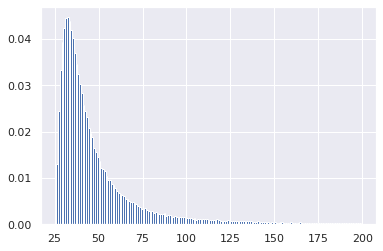

In [10]:
plt.hist(fit_raftery.extract()["N"], bins = range(26, 200), density = True)
plt.show()

### Prior predictive checking

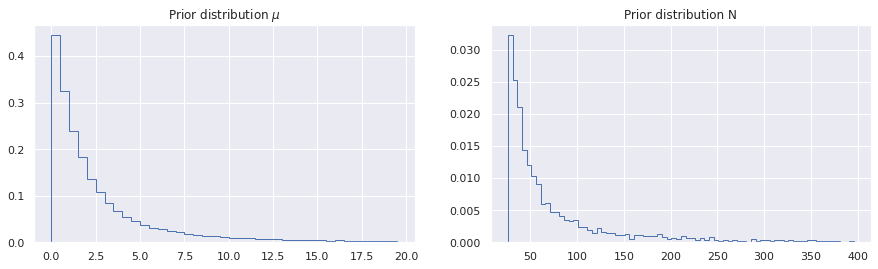

In [11]:
theta = np.random.beta(raft_data["a"], raft_data["b"], 100000)
lambd = np.random.gamma(raft_data["alpha"], raft_data["beta"], 100000)
mu = lambd/theta
N = np.random.poisson(mu)

fig, ax = plt.subplots(1,2,figsize = (15,4))
ax[0].hist(mu, bins = np.arange(0,20,0.5), density = True, histtype = 'step')
ax[1].hist(N, bins = range(26, 400, 5), density = True, histtype = 'step')

ax[1].set_title("Prior distribution N")
ax[0].set_title(r"Prior distribution $\mu$")
plt.show()

In [12]:
uninf_data = {
    "x_obs": impala,
    "n": impala.shape[0],
    'a': 1, 
    'b': 1,
    'alpha': 0,
    'beta': 0,
}

fit_uninf = sm_raft.sampling(data=uninf_data, iter=50000, chains=5,
                             control=dict(adapt_delta=0.95))

print(fit_uninf)

Inference for Stan model: anon_model_696db612137e19e852243acc471e9eb6.
5 chains, each with iter=50000; warmup=25000; thin=1; 
post-warmup draws per chain=25000, total post-warmup draws=125000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta   0.33  1.5e-3    0.2   0.02   0.16   0.31   0.48   0.71  17174    1.0
N     356.16   39.49 5645.3  29.72  43.93  67.03 133.06 1357.3  20436    1.0
lPbar  222.6    0.99 118.64  75.54 138.46 194.78 276.43 528.11  14272    1.0
MME1    0.02  7.2e-5 9.4e-3 7.4e-4 7.5e-3   0.01   0.02   0.03  17087    1.0
MME2  3.3e-4  2.4e-6 3.3e-4 5.4e-7 5.6e-5 2.2e-4 5.2e-4 1.1e-3  17699    1.0
lp__  -16.73  8.0e-3   1.14 -19.79 -17.18 -16.38 -15.92 -15.63  19992    1.0

Samples were drawn using NUTS at Mon Jun  7 23:26:07 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


### Marginal posterior of $N$

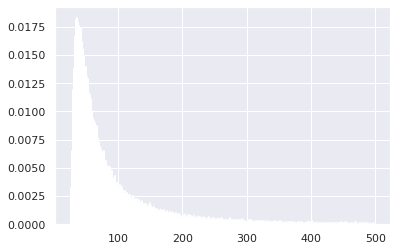

In [13]:
plt.hist(fit_uninf.extract()["N"], bins = range(26, 500), density = True)
plt.show()

In [14]:
geom_id_data = {
    "x_obs": impala,
    "n": impala.shape[0],
    'alpha1': 1, 
    'alpha2': 1,
    'beta1': 1,
    'beta2': 1,
}

fit_geom_id = sm_geom_id.sampling(data=geom_id_data, iter=50000, chains=5,
                                control=dict(adapt_delta=0.99))

print(fit_geom_id)

Inference for Stan model: anon_model_3ba9cd05caf67271b6bbe300ba1e1d2a.
5 chains, each with iter=50000; warmup=25000; thin=1; 
post-warmup draws per chain=25000, total post-warmup draws=125000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
N      64.84     0.5  77.89  28.44  36.63  46.86  67.33  205.8  24499    1.0
theta   0.44  1.1e-3   0.17    0.1   0.31   0.45   0.57   0.75  26183    1.0
nu      0.04  1.7e-4   0.03 3.1e-3   0.02   0.03   0.05   0.12  35773    1.0
MME1    0.02  5.1e-5 8.2e-3 4.9e-3   0.01   0.02   0.03   0.04  25865    1.0
MME2  5.1e-4  2.1e-6 3.4e-4 2.4e-5 2.2e-4 4.6e-4 7.5e-4 1.2e-3  26885    1.0
lp__  -21.95  8.0e-3   1.34 -25.43 -22.55  -21.6 -20.97 -20.43  27817    1.0

Samples were drawn using NUTS at Mon Jun  7 23:26:32 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


### Prior predictive checking

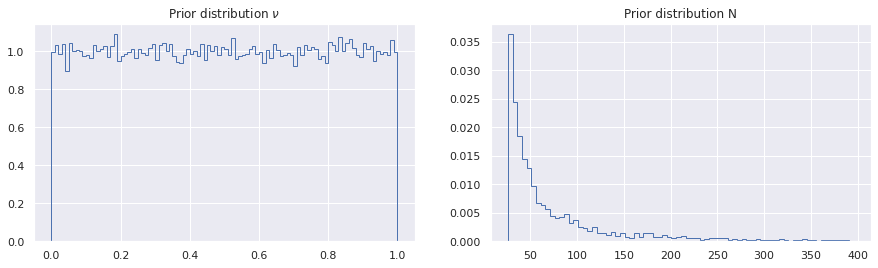

In [15]:
nu = np.random.beta(geom_id_data["alpha1"], geom_id_data["beta1"], 100000)
N = np.random.geometric(nu)

fig, ax = plt.subplots(1,2,figsize = (15,4))
ax[0].hist(nu, bins = 100, density = True, histtype = 'step')
ax[1].hist(N, bins = range(26, 400, 5), density = True, histtype = 'step')

ax[1].set_title("Prior distribution N")
ax[0].set_title(r"Prior distribution $\nu$")
plt.show()

### Marginal posterior of $N$

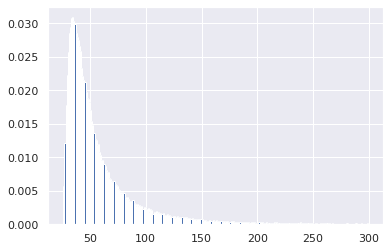

In [16]:
plt.hist(fit_geom_id.extract()["N"], bins = range(26, 300), density = True)
plt.show()

In [17]:
geom_corr_data = {
    "x_obs": impala,
    "n": impala.shape[0],
    'eta': np.array([0,0]), 
    'Sigma': np.array([[2.5,-1],[-1,2.5]]),
}

fit_geom_corr = sm_geom_corr.sampling(data=geom_corr_data, iter=50000, chains=5,
                                 control=dict(adapt_delta=0.96))

print(fit_geom_corr)

Inference for Stan model: anon_model_7c69c4fd31a6b1b0084467fc24a39099.
5 chains, each with iter=50000; warmup=25000; thin=1; 
post-warmup draws per chain=25000, total post-warmup draws=125000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
N               42.43     0.1  17.29  27.29   32.2  37.49  46.62  87.07  31012    1.0
probs_logit[1]  -2.97  3.2e-3   0.68  -4.41   -3.4  -2.94   -2.5  -1.75  44473    1.0
probs_logit[2]    0.2  3.4e-3   0.63  -1.16   -0.2   0.24   0.64   1.28  34734    1.0
theta            0.55  7.6e-4   0.14   0.24   0.45   0.56   0.66   0.78  35252    1.0
nu               0.06  1.6e-4   0.04   0.01   0.03   0.05   0.08   0.15  49635    1.0
MME1             0.03  3.6e-5 6.7e-3   0.01   0.02   0.03   0.03   0.04  34915    1.0
MME2           7.2e-4  1.7e-6 3.3e-4 1.3e-4 4.6e-4 7.1e-4 9.6e-4 1.3e-3  35575    1.0
lp__           -19.66  7.4e-3   1.34 -23.12 -20.26 -19.32 -18.69 -18.15  32563    1.0

Samples were drawn using NUTS a

### Prior predictive checking

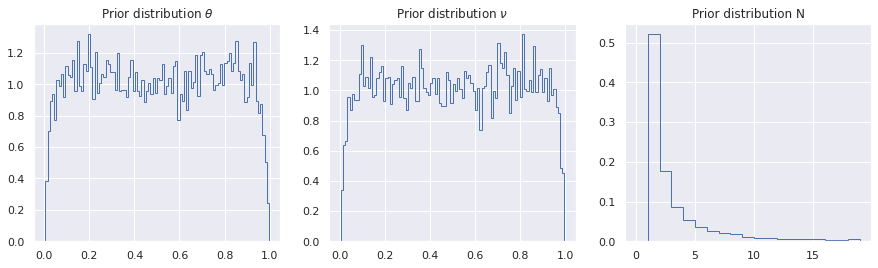

In [18]:
logit_par = np.random.multivariate_normal(geom_corr_data['eta'], geom_corr_data['Sigma'], 10000)

theta = 1/(1 + np.exp(logit_par[:,0]))
nu = 1/(1 + np.exp(logit_par[:,1]))
N = np.random.geometric(nu)

fig, ax = plt.subplots(1,3,figsize = (15,4))
ax[0].hist(theta, bins = 100, density = True, histtype = 'step')
ax[1].hist(nu, bins = 100, density = True, histtype = 'step')
ax[2].hist(N, bins = range(0,20), density = True, histtype = 'step')

ax[2].set_title("Prior distribution N")
ax[0].set_title(r"Prior distribution $\theta$")
ax[1].set_title(r"Prior distribution $\nu$")
plt.show()

### Marginal posterior of $N$

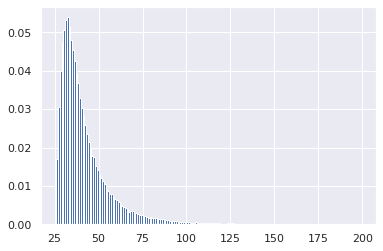

In [19]:
plt.hist(fit_geom_corr.extract()["N"], bins = range(26, 200), density = True)
plt.show()

Figure joining the posteriors of $N$

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


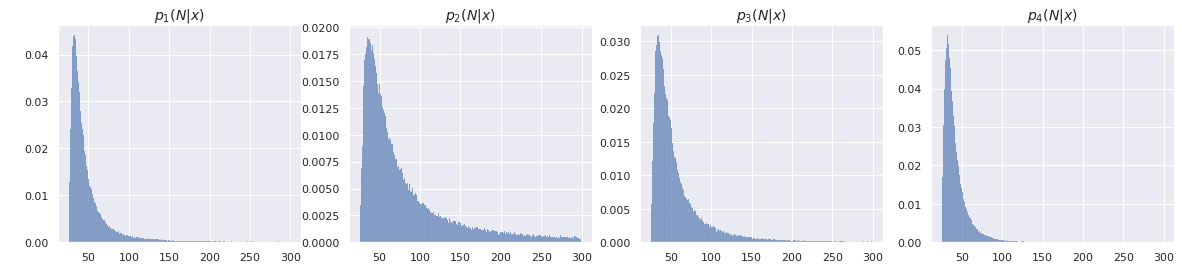

In [20]:
fig, ax = plt.subplots(1,4, figsize = (20,4))

sns.histplot(fit_raftery.extract()["N"], bins = range(26, 300), ax = ax[0], stat = 'density')
sns.histplot(fit_uninf.extract()["N"], bins = range(26, 300),ax = ax[1], stat = 'density')
sns.histplot(fit_geom_id.extract()["N"], bins = range(26, 300), ax = ax[2], stat = 'density')
sns.histplot(fit_geom_corr.extract()["N"], bins = range(26, 300), ax = ax[3], stat = 'density')

for i in range(4):
    ax[i].set_title(r"$p_{}(N|x)$".format(i+1), fontsize = 14)
    ax[i].set_ylabel(" ")

plt.savefig("../images/marginal-distributions.png", bbox_inches = 'tight')    
plt.show()

### Summary statistics

In [21]:
raft_N = fit_raftery.extract()["N"]
uninf_N = fit_uninf.extract()["N"]
geom_id_N = fit_geom_id.extract()["N"]
geom_corr_N = fit_geom_corr.extract()["N"]

se = {
    'Mean': [raft_N.mean(), uninf_N.mean(), geom_id_N.mean(), geom_corr_N.mean()],
    'Median': [np.median(raft_N), np.median(uninf_N), np.median(geom_id_N), np.median(geom_corr_N)],
    'MRSE': [(1/raft_N).mean()/(1/raft_N**2).mean(), (1/uninf_N).mean()/(1/uninf_N**2).mean(),
             (1/geom_id_N).mean()/(1/geom_id_N**2).mean(), (1/geom_corr_N).mean()/(1/geom_corr_N**2).mean()],
    'HDI': [az.hdi(raft_N, hdi_prop = 0.95), az.hdi(uninf_N, hdi_prop = 0.95), 
            az.hdi(geom_id_N, hdi_prop = 0.95), az.hdi(geom_corr_N, hdi_prop = 0.95)]
}

summary_statistics = pd.DataFrame(se)
summary_statistics

,Mean,Median,MRSE,HDI
0,177.70,40.48,37.78,"[26.001448718908023, 123.70020249503489]"
1,356.16,67.03,47.12,"[26.036035627289746, 567.2658567928925]"
2,64.84,46.86,41.41,"[26.0029850961107, 135.66466675581643]"
3,42.43,37.49,36.17,"[26.000040335986057, 69.37022142501675]"


### Waterbuck data

In [22]:
raft_data = {
    "x_obs": waterbuck,
    "n": waterbuck.shape[0],
    'a': 1, 
    'b': 1,
    'alpha': 1.,
    'beta': 1.,
}

fit_raftery = sm_raft.sampling(data=raft_data, iter=50000, chains=5,
                               control=dict(adapt_delta=0.95))

print(fit_raftery)

Inference for Stan model: anon_model_696db612137e19e852243acc471e9eb6.
5 chains, each with iter=50000; warmup=25000; thin=1; 
post-warmup draws per chain=25000, total post-warmup draws=125000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta    0.6  8.1e-4   0.11   0.34   0.54   0.62   0.69   0.79  20259    1.0
N     104.08    0.46  59.62  78.58  88.33  97.16 110.58  167.9  16506    1.0
lPbar 312.16    0.69  94.28 175.12 246.17 297.23 360.55 538.63  18848    1.0
MME1    0.01  1.2e-5 1.7e-3 6.0e-3 9.0e-3   0.01   0.01   0.01  19927    1.0
MME2  1.0e-4  2.3e-7 3.3e-5 3.5e-5 8.2e-5 1.1e-4 1.3e-4 1.6e-4  21002    1.0
lp__   -65.7  7.0e-3   1.07 -68.57 -66.12 -65.37 -64.94 -64.66  23519    1.0

Samples were drawn using NUTS at Mon Jun  7 23:27:02 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


### Marginal posterior of $N$

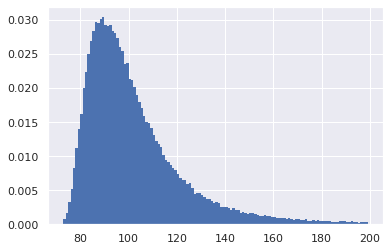

In [23]:
plt.hist(fit_raftery.extract()["N"], bins = range(73, 200), density = True, edgecolor = "none")
plt.show()

In [24]:
uninf_data = {
    "x_obs": waterbuck,
    "n": waterbuck.shape[0],
    'a': 1, 
    'b': 1,
    'alpha': 0,
    'beta': 0,
}

fit_uninf = sm_raft.sampling(data=uninf_data, iter=50000, chains=5,
                             control=dict(adapt_delta=0.95))

print(fit_uninf)

Inference for Stan model: anon_model_696db612137e19e852243acc471e9eb6.
5 chains, each with iter=50000; warmup=25000; thin=1; 
post-warmup draws per chain=25000, total post-warmup draws=125000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta   0.29  1.5e-3   0.18   0.01   0.13   0.27   0.42   0.66  14721    1.0
N     1224.8  154.28  1.8e4  95.17 148.87 235.34 476.21 4948.9  14337    1.0
lPbar 747.16    3.29 361.76 286.57 490.23  666.8 913.52 1670.7  12122    1.0
MME1  4.5e-3  2.4e-5 2.9e-3 2.0e-4 2.1e-3 4.2e-3 6.7e-3   0.01  14736    1.0
MME2  2.9e-5  2.5e-7 3.1e-5 4.1e-8 4.4e-6 1.8e-5 4.5e-5 1.1e-4  15215    1.0
lp__  -19.88  8.1e-3   1.09 -22.83  -20.3 -19.54 -19.11 -18.82  18303    1.0

Samples were drawn using NUTS at Mon Jun  7 23:27:25 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


### Marginal posterior of $N$

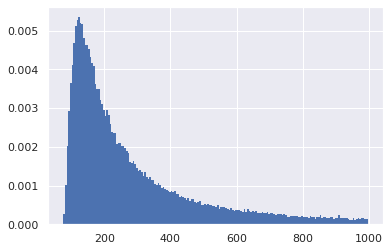

In [25]:
plt.hist(fit_uninf.extract()["N"], bins = range(76, 1000,5), density = True, edgecolor = "none")
plt.show()

In [26]:
geom_id_data = {
    "x_obs": waterbuck,
    "n": waterbuck.shape[0],
    'alpha1': 1, 
    'alpha2': 1,
    'beta1': 1,
    'beta2': 1,
}

fit_geom_id = sm_geom_id.sampling(data=geom_id_data, iter=50000, chains=5,
                                control=dict(adapt_delta=0.99))

print(fit_geom_id)

Inference for Stan model: anon_model_3ba9cd05caf67271b6bbe300ba1e1d2a.
5 chains, each with iter=50000; warmup=25000; thin=1; 
post-warmup draws per chain=25000, total post-warmup draws=125000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
N     214.33    1.76 253.26  88.74 118.12 153.38  224.3 709.59  20781    1.0
theta   0.41  1.1e-3   0.17   0.09   0.28   0.41   0.53   0.71  22367    1.0
nu      0.01  6.0e-5   0.01 9.8e-4 4.9e-3 9.6e-3   0.02   0.04  31994    1.0
MME1  6.4e-3  1.8e-5 2.7e-3 1.4e-3 4.5e-3 6.5e-3 8.5e-3   0.01  22341    1.0
MME2  4.9e-5  2.2e-7 3.5e-5 2.0e-6 2.0e-5 4.3e-5 7.2e-5 1.3e-4  24230    1.0
lp__  -26.21  7.6e-3   1.29 -29.57  -26.8 -25.88 -25.27 -24.73  28755    1.0

Samples were drawn using NUTS at Mon Jun  7 23:28:00 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


### Marginal posterior of $N$

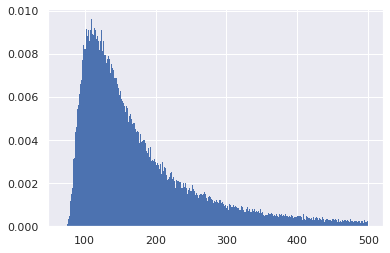

In [27]:
plt.hist(fit_geom_id.extract()["N"], bins = range(70, 500), density = True, edgecolor = "none")
plt.show()

In [28]:
geom_corr_data = {
    "x_obs": waterbuck,
    "n": waterbuck.shape[0],
    'eta': np.array([0,0]), 
    'Sigma': np.array([[2.5,-1],[-1,2.5]]),
}

fit_geom_corr = sm_geom_corr.sampling(data=geom_corr_data, iter=50000, chains=5,
                                 control=dict(adapt_delta=0.96))

print(fit_geom_corr)

Inference for Stan model: anon_model_7c69c4fd31a6b1b0084467fc24a39099.
5 chains, each with iter=50000; warmup=25000; thin=1; 
post-warmup draws per chain=25000, total post-warmup draws=125000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
N              125.98    0.29  44.85   82.3  98.31  113.9 138.89 241.54  24588    1.0
probs_logit[1]  -3.89  3.1e-3   0.62  -5.23  -4.29  -3.85  -3.46  -2.78  39321    1.0
probs_logit[2]   0.18  3.5e-3   0.58  -1.04  -0.19   0.22   0.59   1.21  26805    1.0
theta            0.54  8.1e-4   0.13   0.26   0.45   0.55   0.64   0.77  27018    1.0
nu               0.02  6.6e-5   0.01 5.4e-3   0.01   0.02   0.03   0.06  43284    1.0
MME1           8.6e-3  1.3e-5 2.1e-3 4.1e-3 7.2e-3 8.8e-3   0.01   0.01  26907    1.0
MME2           7.8e-5  2.1e-7 3.5e-5 1.7e-5 5.2e-5 7.7e-5 1.0e-4 1.5e-4  27932    1.0
lp__           -24.65  7.0e-3   1.29  -28.0 -25.22 -24.31 -23.71  -23.2  34127    1.0

Samples were drawn using NUTS a

### Marginal posterior of $N$

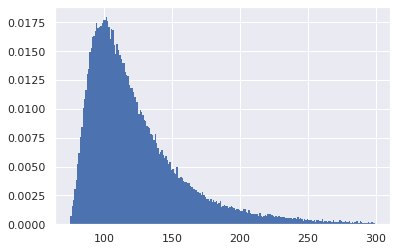

In [29]:
plt.hist(fit_geom_corr.extract()["N"], bins = range(75, 300), density = True, edgecolor = "none")
plt.show()

Figure joining the posteriors of $N$

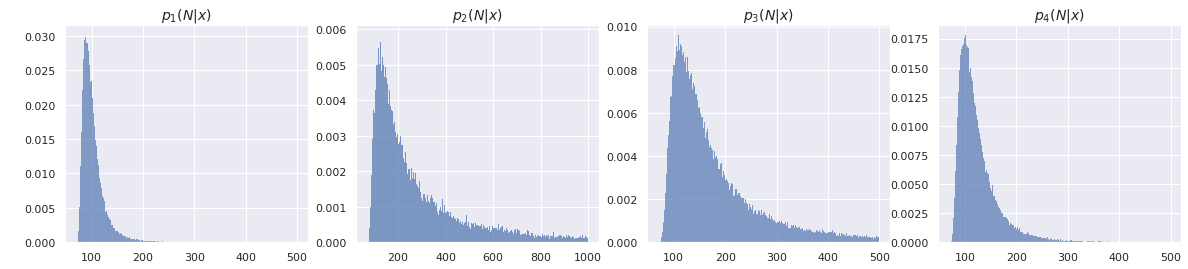

In [30]:
fig, ax = plt.subplots(1,4, figsize = (20,4))

sns.histplot(fit_raftery.extract()["N"], bins = range(70, 500), ax = ax[0], stat = 'density')
sns.histplot(fit_uninf.extract()["N"], bins = range(70, 1000),ax = ax[1], stat = 'density')
sns.histplot(fit_geom_id.extract()["N"], bins = range(70, 500), ax = ax[2], stat = 'density')
sns.histplot(fit_geom_corr.extract()["N"], bins = range(70, 500), ax = ax[3], stat = 'density')

for i in range(4):
    ax[i].set_title(r"$p_{}(N|x)$".format(i+1), fontsize = 14)
    ax[i].set_ylabel(" ")

plt.savefig("../images/marginal-distributions-waterbuck.png", bbox_inches = 'tight')    
plt.show()

### Summary statistics

In [33]:
raft_N = fit_raftery.extract()["N"]
uninf_N = fit_uninf.extract()["N"]
geom_id_N = fit_geom_id.extract()["N"]
geom_corr_N = fit_geom_corr.extract()["N"]

se = {
    'Mean': [raft_N.mean(), uninf_N.mean(), geom_id_N.mean(), geom_corr_N.mean()],
    'Median': [np.median(raft_N), np.median(uninf_N), np.median(geom_id_N), np.median(geom_corr_N)],
    'MRSE': [(1/raft_N).mean()/(1/raft_N**2).mean(), (1/uninf_N).mean()/(1/uninf_N**2).mean(),
             (1/geom_id_N).mean()/(1/geom_id_N**2).mean(), (1/geom_corr_N).mean()/(1/geom_corr_N**2).mean()],
    'HDI': [az.hdi(raft_N, hdi_prop = 0.95), az.hdi(uninf_N, hdi_prop = 0.95), 
            az.hdi(geom_id_N, hdi_prop = 0.95), az.hdi(geom_corr_N, hdi_prop = 0.95)]
}

summary_statistics = pd.DataFrame(se)
summary_statistics.HDI = summary_statistics.HDI.apply(lambda x: [round(x[0],2), round(x[1],2)])
summary_statistics

,Mean,Median,MRSE,HDI
0,104.08,97.16,96.62,"[75.29, 143.63]"
1,1224.80,235.34,155.68,"[76.01, 2072.85]"
2,214.33,153.38,132.56,"[76.31, 456.49]"
3,125.98,113.90,109.71,"[76.43, 199.42]"


## Comparing the simulation to the closed-form distributions

In [85]:
geom_id_data = {
    "x_obs": impala,
    "n": impala.shape[0],
    'alpha1': 1, 
    'alpha2': 1,
    'beta1': 1,
    'beta2': 1,
}

fit_geom_id = sm_geom_id.sampling(data=geom_id_data, iter=50000, chains=5,
                                control=dict(adapt_delta=0.99))

uninf_data = {
    "x_obs": impala,
    "n": impala.shape[0],
    'a': 1, 
    'b': 1,
    'alpha': 0,
    'beta': 0,
}

fit_uninf = sm_raft.sampling(data=uninf_data, iter=50000, chains=5,
                             control=dict(adapt_delta=0.95))

### Geometric distribution

In [126]:
S = sum(impala)
n = len(impala)
xmax = max(impala)

def p1_geom_unnorm(N, x_obs): 
    
    result = np.prod([comb(N,i) for i in x_obs])
    result *= beta(geom_id_data["alpha1"] + 1, N + geom_id_data["beta1"])
    result *= beta(S+geom_id_data["alpha2"], n*N - S + geom_id_data["beta2"])
    return result

constant_geom = 0 
N = xmax
eps = 1
while eps > 1e-16: 
    eps = p1_geom_unnorm(N, impala)
    constant_geom += eps
    N += 1
    
def p1_geom(N, x_obs): 
    
    return p1_geom_unnorm(N, x_obs)/constant_geom

### Raftery uninformative

In [127]:
def p2_uninf_unnorm(N, x_obs): 
    
    result = np.prod([comb(N,i) for i in x_obs])
    d = n*N+1
    while d > n*N - S: 
        result /= d
        d -= 1
    result /= N
    return result*1e179

constant_uninf = 0 
N = xmax
eps = 1
while eps > 0.01: 
    eps = p2_uninf_unnorm(N, impala)
    constant_uninf += eps
    N += 1
    
def p2_uninf(N, x_obs): 
    
    return p2_uninf_unnorm(N, x_obs)/constant_uninf

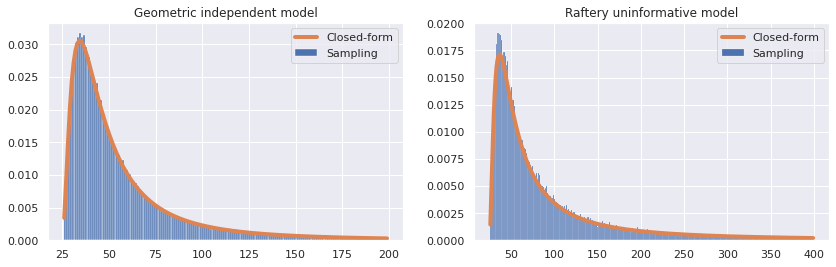

In [134]:
fig, ax = plt.subplots(1,2, figsize = (14,4))

ax[0].hist(fit_geom_id.extract()["N"], bins= range(xmax, 200), density = True, linewidth=0.4, label = "Sampling")
ax[0].plot(range(xmax,200), [p1_geom(N,impala) for N in range(xmax,200)], linewidth = 4, label = "Closed-form")
ax[1].hist(fit_uninf.extract()["N"], bins= range(xmax, 400), density = True, linewidth=0.2, label = "Sampling")
ax[1].plot(range(xmax,400), [p2_uninf(N,impala) for N in range(xmax,400)], linewidth = 4, label = "Closed-form")

ax[0].legend()
ax[1].legend()
ax[0].set_title("Geometric independent model")
ax[1].set_title("Raftery uninformative model")

plt.savefig("../images/approximation-analysis-stan.png")
plt.show()